# Creating Spheres
This program takes the percentage of the mesh that we want to eliminate in the Anterior-Posterior axis.

Creates a folder with the visual representation of every sphere for each condyle from 0 (orginial) to the desired reduction number.


In [31]:
#Create the empty folder
def CreateSphereFolder(ReductionPercentage,MeshFolder):
    folder_path = os.path.join(os.getcwd(),MeshFolder)
    patients = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and len(f) == 3 and f.isnumeric()]
    patients.sort(key=lambda x: int(x))
    legs=['Left','Right']
    spheres=os.path.join(os.getcwd(),'Spheres','Sphere_'+str(ReductionPercentage))
    os.mkdir(spheres)
    for p in range(len(patients)):
        os.mkdir(os.path.join(spheres,patients[p]))
        for l in range(len(legs)): 
            if os.path.exists(os.path.join(folder_path,patients[p],legs[l])):
                os.mkdir(os.path.join(spheres,patients[p],legs[l]))               

In [32]:
#Read meshes
def LoadMesh(filename):
    reader = vtk.vtkPolyDataReader() 
    reader.SetFileName(filename)
    reader.ReadAllScalarsOn()
    reader.ReadAllVectorsOn()
    reader.Update()
    mesh = reader.GetOutput()  
    return mesh

In [33]:
#Fit an sphere to a given mesh
def FitSphere(mesh):
    points = np.array([mesh.GetPoint(i) for i in range(mesh.GetNumberOfPoints())])   
    b = np.zeros(len(points))  
    A = np.zeros((len(points), 4)) 

    for i in range(len(points)):
        b[i] = points[i][0]**2 + points[i][1]**2 + points[i][2]**2      
        A[i] = [2 * points[i][0], 2 * points[i][1], 2 * points[i][2], 1] 

    res = np.linalg.lstsq(A, b, rcond=None)[0]  
    center = vtk.vtkVector3d(res[0], res[1], res[2]) 
    radius = np.sqrt(res[3] + res[0]**2 + res[1]**2 + res[2]**2) 

    return center, radius

In [34]:
#Visual Sphere and center
def CreateSphere(route,S_center,S_radius,condyle):

  sphere = vtk.vtkSphereSource()
  sphere.SetCenter(S_center)
  sphere.SetRadius(S_radius)

  sphere.SetThetaResolution(50)
  sphere.SetPhiResolution(50) 

  writer = vtk.vtkPolyDataWriter()
  writer.SetFileName(os.path.join(route,condyle+"Sphere"+".vtk"))
  writer.SetInputConnection(sphere.GetOutputPort())
  writer.Write()
  
  #Center for visualization:
  sphereC = vtk.vtkSphereSource()
  sphereC.SetCenter(S_center)
  sphereC.SetRadius(1)

  sphereC.SetThetaResolution(50)
  sphereC.SetPhiResolution(50) 

  writer = vtk.vtkPolyDataWriter()
  writer.SetFileName(os.path.join(route,condyle+"SphereCenter"+".vtk"))
  writer.SetInputConnection(sphereC.GetOutputPort())
  writer.Write()

  return

In [35]:
def meshToNumpy(mesh):
    points = mesh.GetPoints()
    numPoints = points.GetNumberOfPoints()
    numpyPoints = np.zeros((numPoints, 3))
    for i in range(numPoints):
        point = points.GetPoint(i)
        numpyPoints[i] = point
    return numpyPoints

def CreateVTKMesh(numpyPoints):
    # Crear un objeto vtkPoints a partir del arreglo NumPy de puntos
    vtk_points = vtk.vtkPoints()
    for point in numpyPoints:
        vtk_points.InsertNextPoint(point)
    
    # Crear un objeto vtkPolyData y establecer los puntos
    mesh = vtk.vtkPolyData()
    mesh.SetPoints(vtk_points)

    # Crear una celda de puntos para todo el conjunto de datos
    num_points = vtk_points.GetNumberOfPoints()
    vertices = vtk.vtkCellArray()
    vertices.InsertNextCell(num_points)
    for i in range(num_points):
        vertices.InsertCellPoint(i)
    mesh.SetVerts(vertices)

    return mesh

def DistanceToPlane(numpyPoints, origin, normal):
    distances = []
    for i in range(len(numpyPoints)):
        point = numpyPoints[i]
        dist = abs(np.dot(np.array(point) - np.array(origin), np.array(normal)))
        distances.append(dist)
    return distances

def OrderPoints(numpyPoints,distances):
    idx = np.argsort(distances)
    numpyPoints=numpyPoints[idx]
    return numpyPoints

def CutPoints(numpyPoints,percentage):
    PointsToDelete=round(len(numpyPoints)* percentage*0.01)
    numpyPoints=numpyPoints[PointsToDelete:]
    return numpyPoints

def MeshCutter(mesh, AxisOrigin, AxisNormal,CutPercentage):
    numpyPoints=meshToNumpy(mesh)
    distances=DistanceToPlane(numpyPoints, AxisOrigin, AxisNormal)
    numpyPoints= OrderPoints(numpyPoints,distances)
    numpyPoints=CutPoints(numpyPoints,CutPercentage)
    meshCut=CreateVTKMesh(numpyPoints)

    return meshCut



In [36]:
def MeshSaver(RouteName,mesh):
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(RouteName)
    writer.SetInputData(mesh)
    writer.Write()

In [37]:
#Take all the meshes from a folder and make all the spheres in a new set of folders
#Could generalize to make simply from here the model space

def FitAllSpheres(CutPercentage,MeshFolder):

    folder_path = os.path.join(os.getcwd(),MeshFolder) #Folders with the vtk spheres
    patients = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and len(f) == 3 and f.isnumeric()]
    patients.sort(key=lambda x: int(x))
    legs=['Left','Right']
    condyle=["Medial","Lateral"]
    space=os.path.join('localization','segSpace','femur')
    

    spheres=os.path.join(os.getcwd(), 'Spheres')
    os.mkdir(spheres)
    
    for i in range(CutPercentage):
        
        CreateSphereFolder(i,MeshFolder)
        #print(i)
        for p in range(len(patients)):
            #print(i)
            for l in range(len(legs)): 
               # print(i)
                if os.path.exists(os.path.join(folder_path,patients[p],legs[l])):
                   # print(i)
                    for c in range(len(condyle)):
                      #  print(i)
                        originRoute = os.path.join(folder_path,patients[p],legs[l],space) #Dossier avec le maiallage
                        destinationRoute=os.path.join(os.getcwd(),'Spheres', 'Sphere_'+str(i),patients[p],legs[l])

                        axis=LoadMesh(os.path.join(originRoute,'ax_Anteroposterior.vtk'))
                        AxisOrigin= axis.GetPoint(0)
                        #El vector saliente es el vector resta entre el origen y el segundo punto
                        AxisNormal= np.array(AxisOrigin) - np.array(axis.GetPoint(1))
                        AxisNormal=AxisNormal/ np.linalg.norm(AxisNormal)                       

                        if c==0:
                            mesh=LoadMesh(os.path.join(originRoute,'ps_post medial condyle.vtk'))
                            MeshCut=MeshCutter(mesh, AxisOrigin, AxisNormal,i)                            
                            Center,Radius=FitSphere(MeshCut)
                            CreateSphere(destinationRoute,Center,Radius,condyle[c])
                            MeshSaver(os.path.join(destinationRoute,'MedialMesh.vtk'),MeshCut)
                        if c==1:
                            mesh=LoadMesh(os.path.join(originRoute,'ps_post lateral condyle.vtk'))
                            MeshCut=MeshCutter(mesh, AxisOrigin, AxisNormal,i) 
                            Center,Radius=FitSphere(MeshCut)
                            CreateSphere(destinationRoute,Center,Radius,condyle[c])
                            MeshSaver(os.path.join(destinationRoute,'LateralMesh.vtk'),MeshCut)


In [ ]:
import shutil

def AddReferences(Folder):
    folder_p = os.path.join(os.getcwd(),Folder) #Spheres
    origin= os.path.join(os.getcwd(),'Folder')
    legs=['Left','Right']
    condyle=["Medial","Lateral"]
    for i in range(len(os.listdir(folder_p))):
        folder_path = os.path.join(os.getcwd(),Folder,'Sphere_'+str(i)) #Cada esfera
        patients = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and len(f) == 3 and f.isnumeric()]
        patients.sort(key=lambda x: int(x))
        for p in range(len(patients)): #dentro de cada esfera cada paciente
            for l in range(len(legs)): 
                if os.path.exists(os.path.join(folder_path,patients[p],legs[l])): #cada pierna
                    destination_route=os.path.join(folder_path,patients[p],legs[l])
                    origin_route=os.path.join(origin,patients[p],legs[l],'localization','segSpace','femur','ax_Reference.vtk')
                    shutil.copy2(origin_route,os.path.join(destination_route,'ax_Reference.vtk'))
                    origin_route=os.path.join(origin,patients[p],legs[l],'localization','segSpace','femur','pt_Trochlea shape lateral distal .vtk')
                    shutil.copy2(origin_route,os.path.join(destination_route,'pt_Trochlea shape lateral distal .vtk'))
                    origin_route=os.path.join(origin,patients[p],legs[l],'localization','segSpace','femur','pt_Trochlea shape medial distal.vtk')
                    shutil.copy2(origin_route,os.path.join(destination_route,'pt_Trochlea shape medial distal .vtk'))
                    origin_route=os.path.join(origin,patients[p],legs[l],'localization','segSpace','femur','ax_Mechanical.vtk')
                    shutil.copy2(origin_route,os.path.join(destination_route,'ax_Mechanical.vtk'))


# Condyle Spheres' Radius
Creates a text log with the average radius of all patients' spheres and the difference between condyles

We use this to compare which mesh gives a sphere that is closest to the theoric ones described in

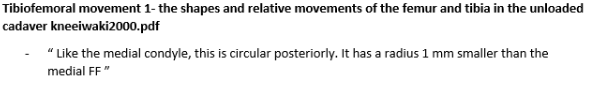

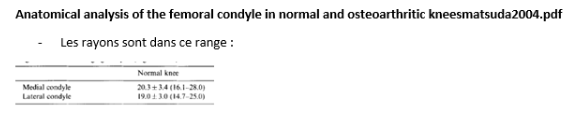


In [39]:
def ExtractRadius(condyle,originRoute):
    #si estoy en el condilo medial va a ser una cosa, en el medial otra. La entrada y la salida
    if condyle==0:
        file='MedialSphere.vtk'
    if condyle==1:
        file='LateralSphere.vtk'
            
        #extraigo todos los valores en un arreglo, promedio cada 3 para tener el promedio en cada coordenada

    with open(os.path.join(originRoute,file), "r") as f:
        content = f.read()
        content=content.split()
        points_number = int(content[11]) # extract number of points
        coords_limit=13+points_number*3
        coords = content[13:coords_limit]
        x=coords[0::3]
        y=coords[1::3]
        z=coords[2::3]
        x=[float(value) for value in x]
        y=[float(value) for value in y]
        z=[float(value) for value in z]
        Center=[]
        Center.append(round(np.mean(x),2))
        Center.append(round(np.mean(y),2))
        Center.append(round(np.mean(z),2))
        
        Radius=np.linalg.norm(np.array(Center)-np.array([x[1],y[1],z[1]]))
        Radius=round(Radius,2)
    
    return Radius

In [8]:
def ExtractCenter(originRoute):

    with open(originRoute, "r") as f:
        content = f.read()
        content=content.split()
        points_number = int(content[11]) # extract number of points
        coords_limit=13+points_number*3
        coords = content[13:coords_limit]
        x=coords[0::3]
        y=coords[1::3]
        z=coords[2::3]
        x=[float(value) for value in x]
        y=[float(value) for value in y]
        z=[float(value) for value in z]
        Center=[]
        Center.append(round(np.mean(x),2))
        Center.append(round(np.mean(y),2))
        Center.append(round(np.mean(z),2))
    
    return Center

In [10]:
def AngleDifference(Line1_Point1,Line1_Point2,Line2_Point1,Line2_Point2,sagital_plane_normal):

    normal=sagital_plane_normal
    origin=[0,0,0]
    Line1 = [0.0, 0.0, 0.0]
    Line2 = [0.0, 0.0, 0.0]
    
    vtk.vtkMath.Subtract(Line1_Point1, Line1_Point2, Line1)
    vtk.vtkMath.Normalize(Line1)
    ProyectedLine1 = [0.0, 0.0, 0.0]
    vtk.vtkPlane.ProjectVector(Line1,origin, normal, ProyectedLine1)

    vtk.vtkMath.Subtract(Line2_Point1, Line2_Point2, Line2)
    vtk.vtkMath.Normalize(Line2)
    ProyectedLine2 = [0.0, 0.0, 0.0]
    vtk.vtkPlane.ProjectVector(Line2,origin, normal, ProyectedLine2)
    
    angle = vtk.vtkMath.AngleBetweenVectors(ProyectedLine1, ProyectedLine2)
    angle = vtk.vtkMath.DegreesFromRadians(angle)
    
    
    #I wanted to make it signed but it sometimes gives the wrong sign
    #cross = np.cross(ProyectedLine1, ProyectedLine2)
    #dot = np.dot(cross, normal)
    #sign = np.sign(dot)
    #angle *= sign
    return angle

In [ ]:
def Angles(condyle,originRoute):
    if condyle==0:
        Mesh='MedialMesh.vtk'
        referenceLow='pt_Trochlea shape medial distal .vtk'
        Center='MedialSphereCenter.vtk'
    if condyle==1:
        Mesh='LateralMesh.vtk'
        referenceLow='pt_Trochlea shape lateral distal .vtk'
        Center='LateralSphereCenter.vtk'
        
    referenceHigh='ax_Mechanical.vtk'
    sagitalPlaneNormal='ax_Reference.vtk'
    
    #The Mechanical axis is used as an approximation of the vertical line.
    #As an approximation of the sagittal plane, the Reference axis is used, which was obtained with the traditional method as a normal.
    
    #sagital_plane_normal
    sagital_plane_normal=[0.0, 0.0, 0.0]    
    
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(os.path.join(originRoute,sagitalPlaneNormal))
    reader.Update()
    points = reader.GetOutput().GetPoints()
    punto1 = list(points.GetPoint(0))
    punto2 = list(points.GetPoint(1))
    vtk.vtkMath.Subtract(punto1, punto2, sagital_plane_normal)
    vtk.vtkMath.Normalize(sagital_plane_normal)
    
    #verticalHighPoint
    #verticalLowPoint
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(os.path.join(originRoute,referenceHigh))
    reader.Update()
    points = reader.GetOutput().GetPoints()
    verticalHighPoint=list(points.GetPoint(0))
    verticalLowPoint= list(points.GetPoint(1))
    
    # CutMeshHighestPoint
    # Reference= verticalHighPoint
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(os.path.join(originRoute,Mesh))
    reader.Update()
    points = reader.GetOutput().GetPoints()
    min_distance = float('inf')
    closest_point = None
    for i in range(reader.GetOutput().GetNumberOfPoints()):
        point = points.GetPoint(i)
        distance = vtk.vtkMath.Distance2BetweenPoints(point, verticalHighPoint)
        if distance < min_distance:
            min_distance = distance
            closest_point = point
    CutMeshHighestPoint=list(closest_point)
    
    # CutMeshLowestPoint
    Low=ExtractCenter(os.path.join(originRoute,referenceLow))

    min_distance = float('inf')
    closest_point = None
    for i in range(reader.GetOutput().GetNumberOfPoints()):
        point = points.GetPoint(i)
        distance = vtk.vtkMath.Distance2BetweenPoints(point, Low)
        if distance < min_distance:
            min_distance = distance
            closest_point = point
    CutMeshLowestPoint=list(closest_point)
    
    #FF
    FF=ExtractCenter(os.path.join(originRoute,Center))
    
    
    InitialAngle=AngleDifference(CutMeshLowestPoint,FF,verticalLowPoint,verticalHighPoint,sagital_plane_normal)
    FinalAngle=AngleDifference(CutMeshHighestPoint,FF,verticalLowPoint,verticalHighPoint,sagital_plane_normal)

    return InitialAngle, FinalAngle

In [48]:
def SphereSize(Folder):


    folder_p = os.path.join(os.getcwd(),Folder) #Folders with the vtk spheres
    os.mkdir(os.path.join(os.getcwd(),'Logs'))
    for i in range(len(os.listdir(folder_p))):
        folder_path = os.path.join(os.getcwd(),Folder,'Sphere_'+str(i))
        patients = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and len(f) == 3 and f.isnumeric()]
        patients.sort(key=lambda x: int(x))
        legs=['Left','Right']
        condyle=["Medial","Lateral"]
        MedialRadius=[]
        LateralRadius=[]
        RadiusDifference=[]
        
        InitialMedialAngle=[]
        FinalMedialAngle=[]    
        InitialLateralAngle=[]
        FinalLateralAngle=[]    
        
        for p in range(len(patients)):
            for l in range(len(legs)): 
                if os.path.exists(os.path.join(folder_path,patients[p],legs[l])):
                    for c in range(len(condyle)):
                            originRoute = os.path.join(folder_path,patients[p],legs[l]) #Dossier avec le maiallage
                            if c==0:
                                MedialRadius.append(ExtractRadius(c,originRoute))
                                initial,final=Angles(c,originRoute)
                                InitialMedialAngle.append(initial)
                                FinalMedialAngle.append(final)
                            if c==1:
                                LateralRadius.append(ExtractRadius(c,originRoute))
                                initial,final=Angles(c,originRoute)
                                InitialLateralAngle.append(initial)
                                FinalLateralAngle.append(final)

        #This sphere is wrong fitted                        
        MedialRadius=np.delete(MedialRadius, 15)
        LateralRadius=np.delete(LateralRadius, 15)
        InitialMedialAngle=np.delete(InitialMedialAngle, 15)
        FinalMedialAngle=np.delete(FinalMedialAngle, 15)
        InitialLateralAngle=np.delete(InitialLateralAngle, 15)
        FinalLateralAngle=np.delete(FinalLateralAngle, 15)
        Individuals = len(MedialRadius)     
        
        #Radius
        Mean_MedialRadius = np.mean(MedialRadius)
        SD_MedialRadius =np.std(MedialRadius)
        Max_MedialRadius = np.max(MedialRadius)
        Min_MedialRadius = np.min(MedialRadius)

        Mean_LateralRadius = np.mean(LateralRadius)    
        SD_LateralRadius =np.std(LateralRadius)
        Max_LateralRadius = np.max(LateralRadius)
        Min_LateralRadius = np.min(LateralRadius)

        RadiusDifference=np.abs(np.array(MedialRadius)-np.array(LateralRadius))        
        Mean_RadiusDifference = np.mean(RadiusDifference)
        SD_RadiusDifference =np.std(RadiusDifference)
        Max_RadiusDifference = np.max(RadiusDifference)
        Min_RadiusDifference = np.min(RadiusDifference)
        
        #Angles        
        Mean_InitialMedialAngle = np.mean(InitialMedialAngle)
        SD_InitialMedialAngle =np.std(InitialMedialAngle)
        Max_InitialMedialAngle = np.max(InitialMedialAngle)
        Min_InitialMedialAngle = np.min(InitialMedialAngle)
        
        Mean_FinalMedialAngle = np.mean(FinalMedialAngle)
        SD_FinalMedialAngle =np.std(FinalMedialAngle)
        Max_FinalMedialAngle = np.max(FinalMedialAngle)
        Min_FinalMedialAngle = np.min(FinalMedialAngle)

        Mean_InitialLateralAngle = np.mean(InitialLateralAngle)
        SD_InitialLateralAngle =np.std(InitialLateralAngle)
        Max_InitialLateralAngle = np.max(InitialLateralAngle)
        Min_InitialLateralAngle = np.min(InitialLateralAngle)
        
        Mean_FinalLateralAngle = np.mean(FinalLateralAngle)
        SD_FinalLateralAngle =np.std(FinalLateralAngle)
        Max_FinalLateralAngle = np.max(FinalLateralAngle)
        Min_FinalLateralAngle = np.min(FinalLateralAngle)        
        
        #Logs        
        with open (os.path.join(os.getcwd(),'Logs',"RadiusDifference"+"_cut_"+str(i)+".txt"),"w") as f:

            f.write("Number of Subjects: " + str(Individuals)+"\n"+"\n" )
            
            f.write("\n///////////////////////////////////////////////////////////////\n")
            
            f.write("Radius difference between Medial and Lateral spheres: \n")
            
            f.write("Medial: \n")
            f.write("Average: "+str(round(Mean_MedialRadius, 2))+"\n")
            f.write("Standar Deviation: "+str(round(SD_MedialRadius, 2))+"\n")
            f.write("Max: "+str(round(Max_MedialRadius, 2))+"\n")
            f.write("Min: "+str(round(Min_MedialRadius, 2))+"\n")

            f.write("\nLateral: \n")
            f.write("Average: "+str(round(Mean_LateralRadius, 2))+"\n")
            f.write("Standar Deviation: "+str(round(SD_LateralRadius, 2))+"\n")
            f.write("Max: "+str(round(Max_LateralRadius, 2))+"\n")
            f.write("Min: "+str(round(Min_LateralRadius, 2))+"\n")

            f.write("\nDifference: \n")
            f.write("Average: "+str(round(Mean_RadiusDifference, 2))+"\n")
            f.write("Standar Deviation: "+str(round(SD_RadiusDifference, 2))+"\n")
            f.write("Max: "+str(round(Max_RadiusDifference, 2))+"\n")
            f.write("Min: "+str(round(Min_RadiusDifference, 2))+"\n")
            
            f.write("\n///////////////////////////////////////////////////////////////\n")
            
            f.write("\nInitial Angle: \n")
            
            f.write("\nMedial: \n")
            f.write("Average: "+str(round(Mean_InitialMedialAngle, 2))+"\n")
            f.write("Standar Deviation: "+str(round(SD_InitialMedialAngle, 2))+"\n")
            f.write("Max: "+str(round(Max_InitialMedialAngle, 2))+"\n")
            f.write("Min: "+str(round(Min_InitialMedialAngle, 2))+"\n")
            
            f.write("\nLateral: \n")
            f.write("Average: "+str(round(Mean_InitialLateralAngle, 2))+"\n")
            f.write("Standar Deviation: "+str(round(SD_InitialLateralAngle, 2))+"\n")
            f.write("Max: "+str(round(Max_InitialLateralAngle, 2))+"\n")
            f.write("Min: "+str(round(Min_InitialLateralAngle, 2))+"\n")
            
            f.write("\n///////////////////////////////////////////////////////////////\n")
            
            f.write("\nFinal Angle: \n")
            
            f.write("\nMedial: \n")
            f.write("Average: "+str(round(Mean_FinalMedialAngle, 2))+"\n")
            f.write("Standar Deviation: "+str(round(SD_FinalMedialAngle, 2))+"\n")
            f.write("Max: "+str(round(Max_FinalMedialAngle, 2))+"\n")
            f.write("Min: "+str(round(Min_FinalMedialAngle, 2))+"\n")
            
            f.write("\nLateral: \n")
            f.write("Average: "+str(round(Mean_FinalLateralAngle, 2))+"\n")
            f.write("Standar Deviation: "+str(round(SD_FinalLateralAngle, 2))+"\n")
            f.write("Max: "+str(round(Max_FinalLateralAngle, 2))+"\n")
            f.write("Min: "+str(round(Min_FinalLateralAngle, 2))+"\n")            
            
            
            
            
            #print(np.argmax(MedialRadius))
            #print(np.argmin(MedialRadius))
            

# Run
In the function fit spheres I have to do a for to do it with all the requested cuts, using the variable CutPercentage that I am already passing it.

In [ ]:
import numpy as np
import os
import vtk

MeshFolder='MeshFolder'
CutPercentage=34 #After 34% cutting, the mesh visually loses many useful points y and the angle is more than 20º

FitAllSpheres(CutPercentage,MeshFolder)

In [25]:
Folder='Spheres'
AddReferences(Folder)

In [ ]:
Folder='Spheres'
SphereSize(Folder) 


#PROBLEM: THE ANGLES ARE SOMETIMES POSITIVE AND SOMETIMES NEGATIVE, THIS WOULD BE SOLVED IF I LEAVE ALL POSITIVE. BUT I LOSE THE DISTINCTION WHEN THE MESH STARTS BEHIND THE FF IN THE FIRST CASES.
#check the maximum and minimum cases first to see if they are so different or if it just fails. 

# Idea of the work
According to:

Tibiofemoral movement 1- the shapes and relative movements of the femur and tibia in the unloaded cadaver kneeiwaki2000.pdf

The total motion of the knee can be roughly simplified by the rotation about two points. 
In the paper they found well the centre of the two rotations.

In this picture we can see the knee rotated at various angles for the medial case (M) and the lateral case (L):
where we see the two axes of rotation EF and FF and different stages of tibial support. AHF and PHF are the very extreme cases where the upper part is already supported. TAF, EF and FF are when I am in the cases of these two circles. On the side it is more difficult to see the separation, I think that's why it joins the two in TAF.

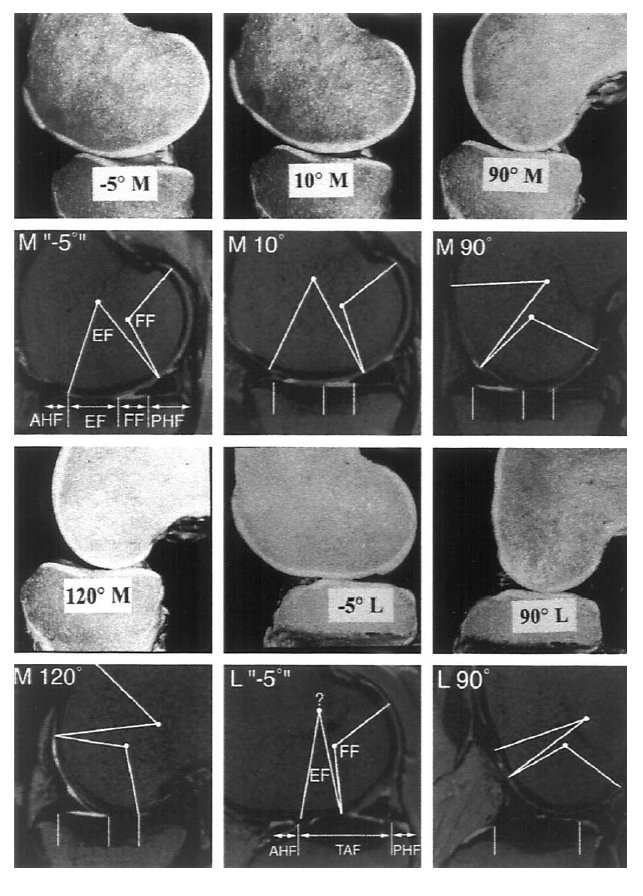

Principle of the measurements. The two ‘wheels’ are composed of the arcs of two circles with centres at A and B. The white rod is fixed to these centres. This rod represents the ‘geometrical axis’ (i.e. the imaginary axle).

For the arc of rotation during which the surfaces a and b are in contact with the plane. When the circular surfaces c and d contact the plane the ‘geometrical axis’ shifts to C and D, connected by the black rod.

According to me, the problem with how the spheres were previously made is that they took points that were part of the centre circles ‘C and D’ and ‘A and B’ and made a single sphere that modelled all of that. However, the appropriate thing to do would be to take the points to model each of the two separately, knowing that in the extension you are going to use black and in the extension white. I start by making the flexion point, which is the one that occurs in most of the movement and is very similar to what we already have. 



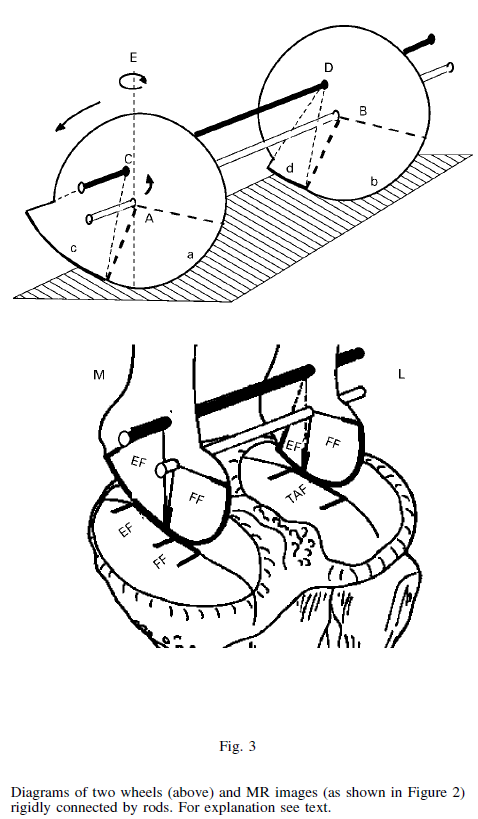

There is an offset of 11º between the EF and the FF because the surface of the tibia is not flat and if we make the normal line that connects the centres with the surface of the tibia we are left with lines with an angle of 11º between them.

From page 5 onwards it talks about how the axis of rotation is not fixed. However, what it shows is how it moves with respect to the tibia, but what it does move is the lateral side especially while the medial side does not change much. Now, if we only look at the femur, this axis seems to me to be stationary.
‘This suggests that the axis of longitudinal rotation is not fixed.’



____________________________________________________

# Characteristics of the circles found in the bibliography

1)

-The medial arc goes from (20+-10)º-120º (or 144º if I take into account the PHF, I think it is better to take it as the centre is the same and I would be having more points to make a better fitting).
-The lateral arc goes from (20+-10)º-124º (or 157º if I take into account the PHF, I think it is better to take it as the centre is the same and I would be having more points to make a better fitting.

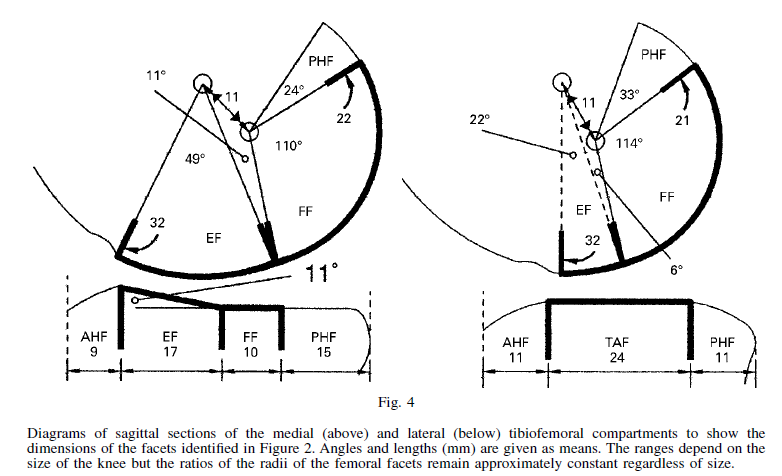

However, with the current method it doesn't seem that this is fulfilled, it seems that the angle between the centre and the lower points is 0º when it should be 20º+-10º.

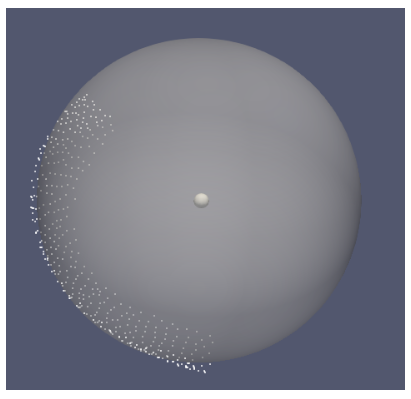

You should check the angle for the upper part.

2)

-1mm difference between lateral and medial radii

3)

Check that the medial and lateral radii are not too far apart from 20.3 mm and 19 mm respectively as it says:

Anatomical analysis of the femoral chondyle in normal and osteoarthritic kneesmatsuda2004.pdf

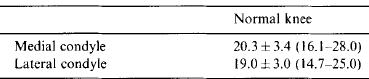


# Procedure for finding a fit according to the literature

The idea is to find the FF centres. Currently we are using points that are too far anterior and correspond to the arc of rotation with EF centre.

1)

Cut out according to the frontal plane the points of the lower part and check for what percentage of cut, the centre found for all patients has an angle of 20º+-10º with the first point of the mesh. 

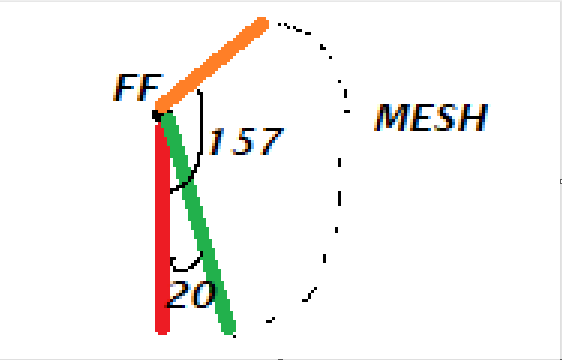

The ones that respect that will be many, say from 5 to 20. Among those I choose the ones that best respond to the characteristics below:

2)

Once the % to be cut has been found, we check that the difference in size between the spheres of each chondyl is consistent with the bibliography.

That is to say:

that the difference in radii is 1 mm

that the lateral radius is 23.3 +- 3.4 mm

that the medial radius is 19 +- 3.0 mm

the angle between the centre of the medial sphere and the upper point of the mesh is close to 144º.

the angle between the centre of the lateral sphere and the upper point of the mesh is close to 157º.


# Possible improvement

I think it's worth discussing but I don't know if it's right or wrong: remove the interior points of the mesh. I don't think they contribute and I think they can cause the sphere to be displaced laterally. 

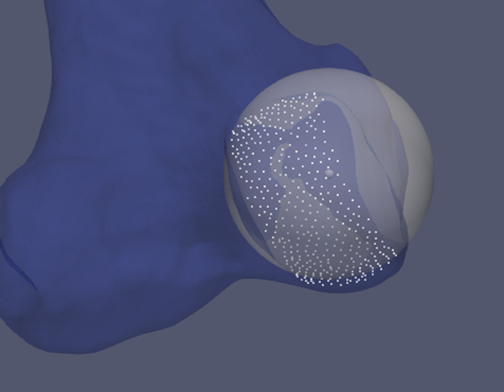

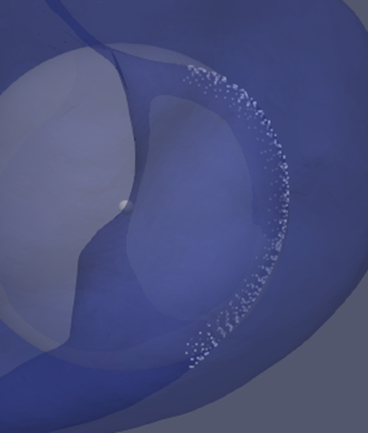

# Log analysis:

Make a file that says:
i could say tell me all the ones that meet this first condition, which can be more than one:

-which is the cut in which the lateral is more like 20 and the max and min are no more than 10 apart.
-The same for the medial

Then 

-that the angle between the centre of the medial sphere and the upper point of the mesh is close to 144º -that the angle between the centre of the medial sphere and the upper point of the mesh is close to 144

-that the angle between the centre of the lateral sphere and the upper point of the mesh is close to 157º -that the angle between the centre of the lateral sphere and the upper point of the mesh is close to 157º.

#I pray that I get something similar

And you have to verify:

-that the difference in radii is 1mm

-that the lateral radius is 23,3 +- 3,4 mm

-that the medial radius is 19 +- 3,0 mm


# Conclusion:

Original spheres:

confidence level 95%, confidence interval: (average +- 2*sigma)

Medial  Radius = (ANONIMIZED +- ANONIMIZED) mm      Theorical = (19.0 +- 3.0) mm

Lateral Radius = (ANONIMIZED +- ANONIMIZED) mm      Theorical = (23.3 +- 3.4) mm

Difference     = (ANONIMIZED  +- ANONIMIZED) mm      Theorical = 1 mm

Medial:

Lower Angle    = (ANONIMIZED +- ANONIMIZED)  º       Theorical = (20 +- 10) º

Higher Angle   = (ANONIMIZED +- ANONIMIZED)  º       Theorical = (144) º

Lateral:

Lower Angle    = (ANONIMIZED +- ANONIMIZED)  º       Theorical = (20 +- 10) º

Higher Angle   = (ANONIMIZED +- ANONIMIZED)  º       Theorical = (157) º

///////////////////////////////////////////////////////////////////////

New method: cutting some anterior points

The option that is closest to the theorical is to cut:

The ANONIMIZED% most anterior Medial  condyle mesh points

The ANONIMIZED% most anterior Lateral condyle mesh points

Results:

confidence level 95%, confidence interval: (average +- 2*sigma)

Medial  Radius = (ANONIMIZED +- ANONIMIZED) mm      Theorical = (19.0 +- 3.0) mm

Lateral Radius = (ANONIMIZED +- ANONIMIZED) mm      Theorical = (23.3 +- 3.4) mm

Difference     = (ANONIMIZED +- ANONIMIZED) mm      Theorical = 1 mm

Medial:
Lower Angle    = (ANONIMIZED +- ANONIMIZED) º       Theorical = (20 +- 10) º

Higher Angle   = (ANONIMIZED +- ANONIMIZED) º       Theorical = (144) º

Lateral:
Lower Angle    = (ANONIMIZED +- ANONIMIZED) º       Theorical = (20 +- 10) º

Higher Angle   = (ANONIMIZED +- ANONIMIZED) º       Theorical = (157) º

I have no easy way to check visually if the upper points taken are some degrees to one side or the other, I could only suggest to have a more upper points in the lateral case to get a more precise approximation of the lateral sphere.


In [ ]:
def Conclusion(Folder):
    MedialRadius=[]
    LateralRadius=[]
    RadiusDifference=[]

    InitialMedialAngle=[]
    FinalMedialAngle=[]    
    InitialLateralAngle=[]
    FinalLateralAngle=[] 

    folder_p = os.path.join(os.getcwd(),Folder) #Folders with the vtk spheres
    os.mkdir(os.path.join(os.getcwd(),'Conclusion'))
    
    folder_path_ANONIMIZED = os.path.join(os.getcwd(),Folder,'Sphere_ANONIMIZED')
    folder_path_ANONIMIZED_2 = os.path.join(os.getcwd(),Folder,'Sphere_ANONIMIZED_2')

    patients = [f for f in os.listdir(folder_path_ANONIMIZED) if os.path.isdir(os.path.join(folder_path_ANONIMIZED, f)) and len(f) == 3 and f.isnumeric()]
    patients.sort(key=lambda x: int(x))
    legs=['Left','Right']
    condyle=["Medial","Lateral"]

    for p in range(len(patients)):
        for l in range(len(legs)): 
            if os.path.exists(os.path.join(folder_path_ANONIMIZED,patients[p],legs[l])):
                for c in range(len(condyle)):
                    originRoute_ANONIMIZED = os.path.join(folder_path_ANONIMIZED,patients[p],legs[l]) #Dossier avec le maiallage medial
                    originRoute_ANONIMIZED_2 = os.path.join(folder_path_ANONIMIZED_2,patients[p],legs[l]) #Dossier avec le maiallage lateral
                    if c==0:
                        MedialRadius.append(ExtractRadius(c,originRoute_ANONIMIZED))
                        initial,final=Angles(c,originRoute_ANONIMIZED)
                        InitialMedialAngle.append(initial)
                        FinalMedialAngle.append(final)
                    if c==1:
                        LateralRadius.append(ExtractRadius(c,originRoute_ANONIMIZED_2))
                        initial,final=Angles(c,originRoute_ANONIMIZED_2)
                        InitialLateralAngle.append(initial)
                        FinalLateralAngle.append(final)

    #This sphere is wrong fitted                        
    MedialRadius=np.delete(MedialRadius, 15)
    LateralRadius=np.delete(LateralRadius, 15)
    InitialMedialAngle=np.delete(InitialMedialAngle, 15)
    FinalMedialAngle=np.delete(FinalMedialAngle, 15)
    InitialLateralAngle=np.delete(InitialLateralAngle, 15)
    FinalLateralAngle=np.delete(FinalLateralAngle, 15)
    Individuals = len(MedialRadius)     

    #Radius
    Mean_MedialRadius = np.mean(MedialRadius)
    SD_MedialRadius =np.std(MedialRadius)
    Max_MedialRadius = np.max(MedialRadius)
    Min_MedialRadius = np.min(MedialRadius)

    Mean_LateralRadius = np.mean(LateralRadius)    
    SD_LateralRadius =np.std(LateralRadius)
    Max_LateralRadius = np.max(LateralRadius)
    Min_LateralRadius = np.min(LateralRadius)

    RadiusDifference=np.abs(np.array(MedialRadius)-np.array(LateralRadius))        
    Mean_RadiusDifference = np.mean(RadiusDifference)
    SD_RadiusDifference =np.std(RadiusDifference)
    Max_RadiusDifference = np.max(RadiusDifference)
    Min_RadiusDifference = np.min(RadiusDifference)

    #Angles        
    Mean_InitialMedialAngle = np.mean(InitialMedialAngle)
    SD_InitialMedialAngle =np.std(InitialMedialAngle)
    Max_InitialMedialAngle = np.max(InitialMedialAngle)
    Min_InitialMedialAngle = np.min(InitialMedialAngle)

    Mean_FinalMedialAngle = np.mean(FinalMedialAngle)
    SD_FinalMedialAngle =np.std(FinalMedialAngle)
    Max_FinalMedialAngle = np.max(FinalMedialAngle)
    Min_FinalMedialAngle = np.min(FinalMedialAngle)

    Mean_InitialLateralAngle = np.mean(InitialLateralAngle)
    SD_InitialLateralAngle =np.std(InitialLateralAngle)
    Max_InitialLateralAngle = np.max(InitialLateralAngle)
    Min_InitialLateralAngle = np.min(InitialLateralAngle)

    Mean_FinalLateralAngle = np.mean(FinalLateralAngle)
    SD_FinalLateralAngle =np.std(FinalLateralAngle)
    Max_FinalLateralAngle = np.max(FinalLateralAngle)
    Min_FinalLateralAngle = np.min(FinalLateralAngle)        

    #Logs        
    with open (os.path.join(os.getcwd(),'Conclusion',"Conclusion"+".txt"),"w") as f:
        
        f.write("Using cut ANONIMIZED% for medial condyle and ANONIMIZED% for lateral condyle: \n")

        f.write("Number of Subjects: " + str(Individuals)+"\n"+"\n" )

        f.write("\n///////////////////////////////////////////////////////////////\n")

        f.write("Radius difference between Medial and Lateral spheres: \n")

        f.write("Medial: \n")
        f.write("Average: "+str(round(Mean_MedialRadius, 2))+"\n")
        f.write("Standar Deviation: "+str(round(SD_MedialRadius, 2))+"\n")
        f.write("Max: "+str(round(Max_MedialRadius, 2))+"\n")
        f.write("Min: "+str(round(Min_MedialRadius, 2))+"\n")

        f.write("\nLateral: \n")
        f.write("Average: "+str(round(Mean_LateralRadius, 2))+"\n")
        f.write("Standar Deviation: "+str(round(SD_LateralRadius, 2))+"\n")
        f.write("Max: "+str(round(Max_LateralRadius, 2))+"\n")
        f.write("Min: "+str(round(Min_LateralRadius, 2))+"\n")

        f.write("\nDifference: \n")
        f.write("Average: "+str(round(Mean_RadiusDifference, 2))+"\n")
        f.write("Standar Deviation: "+str(round(SD_RadiusDifference, 2))+"\n")
        f.write("Max: "+str(round(Max_RadiusDifference, 2))+"\n")
        f.write("Min: "+str(round(Min_RadiusDifference, 2))+"\n")

        f.write("\n///////////////////////////////////////////////////////////////\n")

        f.write("\nInitial Angle: \n")

        f.write("\nMedial: \n")
        f.write("Average: "+str(round(Mean_InitialMedialAngle, 2))+"\n")
        f.write("Standar Deviation: "+str(round(SD_InitialMedialAngle, 2))+"\n")
        f.write("Max: "+str(round(Max_InitialMedialAngle, 2))+"\n")
        f.write("Min: "+str(round(Min_InitialMedialAngle, 2))+"\n")

        f.write("\nLateral: \n")
        f.write("Average: "+str(round(Mean_InitialLateralAngle, 2))+"\n")
        f.write("Standar Deviation: "+str(round(SD_InitialLateralAngle, 2))+"\n")
        f.write("Max: "+str(round(Max_InitialLateralAngle, 2))+"\n")
        f.write("Min: "+str(round(Min_InitialLateralAngle, 2))+"\n")

        f.write("\n///////////////////////////////////////////////////////////////\n")

        f.write("\nFinal Angle: \n")

        f.write("\nMedial: \n")
        f.write("Average: "+str(round(Mean_FinalMedialAngle, 2))+"\n")
        f.write("Standar Deviation: "+str(round(SD_FinalMedialAngle, 2))+"\n")
        f.write("Max: "+str(round(Max_FinalMedialAngle, 2))+"\n")
        f.write("Min: "+str(round(Min_FinalMedialAngle, 2))+"\n")

        f.write("\nLateral: \n")
        f.write("Average: "+str(round(Mean_FinalLateralAngle, 2))+"\n")
        f.write("Standar Deviation: "+str(round(SD_FinalLateralAngle, 2))+"\n")
        f.write("Max: "+str(round(Max_FinalLateralAngle, 2))+"\n")
        f.write("Min: "+str(round(Min_FinalLateralAngle, 2))+"\n")           

In [61]:
Conclusion('Spheres')

In [ ]:
def Conclusion2(Folder):
    folder_p = os.path.join(os.getcwd(),Folder) #Folders with the vtk spheres
    destination=os.path.join(os.getcwd(),'Conclusion')
    origin= os.path.join(os.getcwd(),'Folder')

    folder_path_ANONIMIZED = os.path.join(os.getcwd(),Folder,'Sphere_ANONIMIZED')
    folder_path_ANONIMIZED_2 = os.path.join(os.getcwd(),Folder,'Sphere_ANONIMIZED')

    patients = [f for f in os.listdir(folder_path_ANONIMIZED) if os.path.isdir(os.path.join(folder_path_ANONIMIZED, f)) and len(f) == 3 and f.isnumeric()]
    patients.sort(key=lambda x: int(x))
    legs=['Left','Right']
    condyle=["Medial","Lateral"]
    

    for p in range(len(patients)):
        patientRoute=os.path.join(destination,patients[p])
        os.mkdir(patientRoute)
        for l in range(len(legs)): 
            if os.path.exists(os.path.join(folder_path_ANONIMIZED,patients[p],legs[l])):
                legRoute=os.path.join(patientRoute,legs[l])
                os.mkdir(legRoute)
    
                origin_route=os.path.join(origin,patients[p],legs[l],'segmentation','femur.stl')
                shutil.copy2(origin_route,os.path.join(legRoute,'femur.stl'))
                
                for c in range(len(condyle)):
                    originRoute_ANONIMIZED = os.path.join(folder_path_ANONIMIZED,patients[p],legs[l]) #Dossier avec le maiallage medial
                    originRoute_ANONIMIZED_2 = os.path.join(folder_path_ANONIMIZED_2,patients[p],legs[l]) #Dossier avec le maiallage lateral
                    if c==0:#Medial ANONIMIZED
                        shutil.copy2(os.path.join(originRoute_ANONIMIZED,'ax_Mechanical.vtk'),os.path.join(legRoute,'ax_Mechanical.vtk'))
                        shutil.copy2(os.path.join(originRoute_ANONIMIZED,'ax_Reference.vtk'),os.path.join(legRoute,'ax_Reference.vtk'))
                        
                        shutil.copy2(os.path.join(originRoute_ANONIMIZED,'MedialMesh.vtk'),os.path.join(legRoute,'MedialMesh.vtk'))
                        shutil.copy2(os.path.join(originRoute_ANONIMIZED,'MedialSphere.vtk'),os.path.join(legRoute,'MedialSphere.vtk'))
                        shutil.copy2(os.path.join(originRoute_ANONIMIZED,'MedialSphereCenter.vtk'),os.path.join(legRoute,'MedialSphereCenter.vtk'))
                        shutil.copy2(os.path.join(originRoute_ANONIMIZED,'pt_Trochlea shape medial distal .vtk'),os.path.join(legRoute,'pt_Trochlea shape medial distal .vtk'))

                    if c==1:#Lateral ANONIMIZED_2
                        shutil.copy2(os.path.join(originRoute_ANONIMIZED_2,'LateralMesh.vtk'),os.path.join(legRoute,'LateralMesh.vtk'))
                        shutil.copy2(os.path.join(originRoute_ANONIMIZED_2,'LateralSphere.vtk'),os.path.join(legRoute,'LateralSphere.vtk'))
                        shutil.copy2(os.path.join(originRoute_ANONIMIZED_2,'LateralSphereCenter.vtk'),os.path.join(legRoute,'LateralSphereCenter.vtk'))
                        shutil.copy2(os.path.join(originRoute_ANONIMIZED_2,'pt_Trochlea shape lateral distal .vtk'),os.path.join(legRoute,'pt_Trochlea shape lateral distal .vtk'))

In [4]:
import numpy as np
import os
import vtk
import shutil

Folder='Spheres'
Conclusion2(Folder)

# Angle comparison

I want to compare the angle of the axis in the new cut Mesh compared that of the original.

I will do it with respect to the resection and posterior planes.

I have to:

For each patient:

get the 2 centres of the traditional method using extract center in sphere_0

get the 2 centres from the new method using extract centre in conclusions

get the posterior and anterior plane of each leg and place them in the corresponding folder

get the normal of each plane

use the angle difference function to compare the angle according to the posterior and resection plane

make a text file for each side

make a text file that makes the statistics taking into account everything and save it in a file in the conclusions folder.



In [ ]:
def AngleConclusion():
    folder_path = os.path.join(os.getcwd(),'Spheres','Sphere_0')
    patients = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and len(f) == 3 and f.isnumeric()]
    patients.sort(key=lambda x: int(x))
    legs=['Left','Right']
    condyle=["Medial","Lateral"]
    
    folder_path2 = os.path.join(os.getcwd(),'Conclusion')
    
    AllAngles_resectionPlane=[]
    AllAngles_posteriorPlane=[]
    
    for p in range(len(patients)):
        for l in range(len(legs)): 
            if os.path.exists(os.path.join(folder_path,patients[p],legs[l])):
                CentreMedialO =ExtractCenter(os.path.join(folder_path,patients[p],legs[l], 'MedialSphereCenter.vtk')) #O=original N=new
                CentreLateralO=ExtractCenter(os.path.join(folder_path,patients[p],legs[l],'LateralSphereCenter.vtk')) #O=original N=new

                CentreMedialN =ExtractCenter(os.path.join(folder_path2,patients[p],legs[l], 'MedialSphereCenter.vtk')) #O=original N=new
                CentreLateralN=ExtractCenter(os.path.join(folder_path2,patients[p],legs[l],'LateralSphereCenter.vtk')) #O=original N=new

                #Add plans to each folder
                posteriorPlane= os.path.join(os.getcwd(), 'Folder',patients[p],legs[l],'localization','segSpace','femur',"pl_Posterior.vtk")
                resectionPlane= os.path.join(os.getcwd(), 'Folder',patients[p],legs[l],'localization','segSpace','femur',"pl_Distal resection.vtk")
                         
                shutil.copy2(posteriorPlane,os.path.join(folder_path2,patients[p],legs[l],'pl_Posterior.vtk'))
                shutil.copy2(resectionPlane,os.path.join(folder_path2,patients[p],legs[l],'pl_Distal resection.vtk'))   

                #Read the planes normal
                with open (os.path.join(folder_path2,patients[p],legs[l],'pl_Posterior.vtk'),"r") as f:
                    normal_posteriorPlane= [float(n) for n in f.readlines()[12].split()[0:3]]

                with open (os.path.join(folder_path2,patients[p],legs[l],'pl_Distal resection.vtk'),"r") as f:
                    normal_resectionPlane= [float(n) for n in f.readlines()[12].split()[0:3]]
                    
                Angle_Between_Axis_posteriorPlane=AngleDifference(CentreMedialO,CentreLateralO,CentreMedialN,CentreLateralN,normal_posteriorPlane)
                AllAngles_posteriorPlane.append(Angle_Between_Axis_posteriorPlane)
               
                Angle_Between_Axis_resectionPlane=AngleDifference(CentreMedialO,CentreLateralO,CentreMedialN,CentreLateralN,normal_resectionPlane)
                AllAngles_resectionPlane.append(Angle_Between_Axis_resectionPlane)    
                
                with open (os.path.join(folder_path2,patients[p],legs[l],"AngleComparisonWithOriginal.txt"),"w") as f:
                    f.write("OriginalMedialCenter:     ")
                    f.write(" ".join(map(str, CentreMedialO))+"\n")
                    f.write("NewMedialCenter:  ")
                    f.write(" ".join(map(str, CentreMedialN))+"\n")
                    f.write("OriginalLateralCenter:    ")
                    f.write(" ".join(map(str, CentreLateralO))+"\n")
                    f.write("NewLateralCenter: ")
                    f.write(" ".join(map(str, CentreLateralN))+"\n")
                    f.write("\nAngle between the Old Axis and the New Axis according to different plans (º): \n")
                    f.write("Posterior: "+str(Angle_Between_Axis_posteriorPlane)+"\n")
                    f.write("Resection: "+str(Angle_Between_Axis_resectionPlane)+"\n")
                
                #Create a line to visualize the axis
                OriginalAxis = vtk.vtkLineSource()
                OriginalAxis.SetPoint1(np.array(CentreMedialO))  # Seteamos el primer punto
                OriginalAxis.SetPoint2(np.array(CentreLateralO))  # Seteamos el segundo punto
                OriginalAxis.Update()
                
                writer = vtk.vtkPolyDataWriter()
                writer.SetFileName(os.path.join(folder_path2,patients[p],legs[l],"OriginalAxis.vtk"))
                writer.SetInputConnection(OriginalAxis.GetOutputPort())
                writer.Write()
                
                NewAxis = vtk.vtkLineSource()
                NewAxis.SetPoint1(np.array(CentreMedialN))  # Seteamos el primer punto
                NewAxis.SetPoint2(np.array(CentreLateralN))  # Seteamos el segundo punto
                NewAxis.Update()
                
                writer = vtk.vtkPolyDataWriter()
                writer.SetFileName(os.path.join(folder_path2,patients[p],legs[l],"NewAxis.vtk"))
                writer.SetInputConnection(NewAxis.GetOutputPort())
                writer.Write()
                
                 #This mesh is wrong fitted   
                    
    AllAngles_resectionPlane=np.delete(AllAngles_resectionPlane, 15)
    AllAngles_posteriorPlane=np.delete(AllAngles_posteriorPlane, 15)    

    NumberOfAngles_resectionPlane = len(AllAngles_resectionPlane)            
    MeanAngle_resectionPlane = np.mean(AllAngles_resectionPlane)
    SD_MeanAngle_resectionPlane =np.std(AllAngles_resectionPlane)
    MaxAngle_resectionPlane = np.max(AllAngles_resectionPlane)
    MinAngle_resectionPlane = np.min(AllAngles_resectionPlane)

    NumberOfAngles_posteriorPlane = len(AllAngles_posteriorPlane)
    MeanAngle_posteriorPlane = np.mean(AllAngles_posteriorPlane)    
    SD_MeanAngle_posteriorPlane =np.std(AllAngles_posteriorPlane)
    MaxAngle_posteriorPlane = np.max(AllAngles_posteriorPlane)
    MinAngle_posteriorPlane = np.min(AllAngles_posteriorPlane)
    
    with open (os.path.join(os.getcwd(),'Conclusion',"Angle between axis.txt"),"w") as f:
        f.write("Average angle between the New Axis and the Original Axis according to different plans (º): \n")

        f.write("Number of Subjects: " + str(NumberOfAngles_resectionPlane)+"\n"+"\n" )

        f.write("Resection: \n")
        f.write("Average: "+str(round(MeanAngle_resectionPlane, 2))+"\n")
        f.write("Standar Deviation: "+str(round(SD_MeanAngle_resectionPlane, 2))+"\n")
        f.write("Max: "+str(round(MaxAngle_resectionPlane, 2))+"\n")
        f.write("Min: "+str(round(MinAngle_resectionPlane, 2))+"\n")


        f.write("\nPosterior: \n")
        f.write("Average: "+str(round(MeanAngle_posteriorPlane, 2))+"\n")
        f.write("Standar Deviation: "+str(round(SD_MeanAngle_posteriorPlane, 2))+"\n")
        f.write("Max: "+str(round(MaxAngle_posteriorPlane, 2))+"\n")
        f.write("Min: "+str(round(MinAngle_posteriorPlane, 2))+"\n")
   
    return

In [19]:
AngleConclusion()